In [121]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

In [122]:
from torchvision import datasets
import torchvision.transforms as transforms

def load_dataset():
    data_path = 'maps/'
    train_dataset = datasets.ImageFolder(
        root=data_path,
        transform=transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [123]:
train_loader = load_dataset()

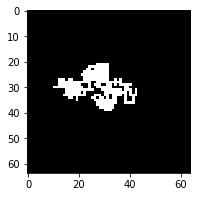

In [124]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
#ax.imshow(img, cmap='gray')
ax.imshow(np.transpose(images[0], (1, 2, 0)))

In [125]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 64*64)
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)

        return out



In [126]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out

In [127]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 64*64
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 64*64
# Size of first hidden layer in the generator
g_hidden_size = 32

In [128]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=4096, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [129]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [130]:
import torch.optim as optim

# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [131]:
import pickle as pkl

# training hyperparams
num_epochs = 1000

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/ 1000] | d_loss: 1.3659 | g_loss: 0.6817
Epoch [    2/ 1000] | d_loss: 1.2985 | g_loss: 0.7134
Epoch [    3/ 1000] | d_loss: 1.5305 | g_loss: 0.6335
Epoch [    4/ 1000] | d_loss: 1.8432 | g_loss: 0.6100
Epoch [    5/ 1000] | d_loss: 0.5067 | g_loss: 3.2504
Epoch [    6/ 1000] | d_loss: 0.5408 | g_loss: 3.7058
Epoch [    7/ 1000] | d_loss: 1.1523 | g_loss: 0.7755
Epoch [    8/ 1000] | d_loss: 0.7476 | g_loss: 1.7284
Epoch [    9/ 1000] | d_loss: 0.9108 | g_loss: 1.3266
Epoch [   10/ 1000] | d_loss: 1.0386 | g_loss: 0.8611
Epoch [   11/ 1000] | d_loss: 0.7590 | g_loss: 2.0254
Epoch [   12/ 1000] | d_loss: 1.1220 | g_loss: 1.4882
Epoch [   13/ 1000] | d_loss: 0.9103 | g_loss: 2.7162
Epoch [   14/ 1000] | d_loss: 0.5233 | g_loss: 4.0165
Epoch [   15/ 1000] | d_loss: 0.6934 | g_loss: 2.2108
Epoch [   16/ 1000] | d_loss: 0.4354 | g_loss: 4.6034
Epoch [   17/ 1000] | d_loss: 0.4837 | g_loss: 4.2586
Epoch [   18/ 1000] | d_loss: 1.1365 | g_loss: 1.1850
Epoch [   19/ 1000] | d_loss

Epoch [  153/ 1000] | d_loss: 0.8890 | g_loss: 2.1997
Epoch [  154/ 1000] | d_loss: 0.8568 | g_loss: 2.0550
Epoch [  155/ 1000] | d_loss: 1.0379 | g_loss: 1.6676
Epoch [  156/ 1000] | d_loss: 0.8757 | g_loss: 2.0453
Epoch [  157/ 1000] | d_loss: 0.8718 | g_loss: 2.1710
Epoch [  158/ 1000] | d_loss: 0.8673 | g_loss: 2.4772
Epoch [  159/ 1000] | d_loss: 0.9450 | g_loss: 2.6082
Epoch [  160/ 1000] | d_loss: 0.8992 | g_loss: 2.4598
Epoch [  161/ 1000] | d_loss: 0.7600 | g_loss: 2.3120
Epoch [  162/ 1000] | d_loss: 0.7875 | g_loss: 2.9827
Epoch [  163/ 1000] | d_loss: 1.0401 | g_loss: 2.9700
Epoch [  164/ 1000] | d_loss: 0.9189 | g_loss: 1.9231
Epoch [  165/ 1000] | d_loss: 0.7275 | g_loss: 2.0864
Epoch [  166/ 1000] | d_loss: 0.7617 | g_loss: 2.7343
Epoch [  167/ 1000] | d_loss: 0.9713 | g_loss: 1.3340
Epoch [  168/ 1000] | d_loss: 1.0233 | g_loss: 3.1292
Epoch [  169/ 1000] | d_loss: 0.9326 | g_loss: 1.6376
Epoch [  170/ 1000] | d_loss: 1.0623 | g_loss: 1.0907
Epoch [  171/ 1000] | d_loss

Epoch [  305/ 1000] | d_loss: 1.1821 | g_loss: 1.5372
Epoch [  306/ 1000] | d_loss: 1.0713 | g_loss: 1.7061
Epoch [  307/ 1000] | d_loss: 0.9749 | g_loss: 2.8898
Epoch [  308/ 1000] | d_loss: 1.0606 | g_loss: 1.4255
Epoch [  309/ 1000] | d_loss: 1.1422 | g_loss: 1.5601
Epoch [  310/ 1000] | d_loss: 1.0768 | g_loss: 1.2779
Epoch [  311/ 1000] | d_loss: 0.9575 | g_loss: 2.6794
Epoch [  312/ 1000] | d_loss: 0.8325 | g_loss: 2.6895
Epoch [  313/ 1000] | d_loss: 1.0409 | g_loss: 1.9081
Epoch [  314/ 1000] | d_loss: 0.9996 | g_loss: 2.4552
Epoch [  315/ 1000] | d_loss: 1.0638 | g_loss: 2.3936
Epoch [  316/ 1000] | d_loss: 1.1222 | g_loss: 1.9319
Epoch [  317/ 1000] | d_loss: 1.0499 | g_loss: 1.6708
Epoch [  318/ 1000] | d_loss: 1.0834 | g_loss: 1.2651
Epoch [  319/ 1000] | d_loss: 1.0557 | g_loss: 2.1747
Epoch [  320/ 1000] | d_loss: 1.0990 | g_loss: 2.2585
Epoch [  321/ 1000] | d_loss: 1.0933 | g_loss: 1.6430
Epoch [  322/ 1000] | d_loss: 1.1252 | g_loss: 1.2856
Epoch [  323/ 1000] | d_loss

Epoch [  457/ 1000] | d_loss: 1.1954 | g_loss: 1.0069
Epoch [  458/ 1000] | d_loss: 1.1964 | g_loss: 1.4357
Epoch [  459/ 1000] | d_loss: 1.1121 | g_loss: 1.8540
Epoch [  460/ 1000] | d_loss: 1.1816 | g_loss: 1.1756
Epoch [  461/ 1000] | d_loss: 1.0276 | g_loss: 2.7564
Epoch [  462/ 1000] | d_loss: 1.2940 | g_loss: 1.2151
Epoch [  463/ 1000] | d_loss: 1.3161 | g_loss: 1.2116
Epoch [  464/ 1000] | d_loss: 1.1793 | g_loss: 2.0467
Epoch [  465/ 1000] | d_loss: 1.1958 | g_loss: 1.0191
Epoch [  466/ 1000] | d_loss: 1.2862 | g_loss: 0.9713
Epoch [  467/ 1000] | d_loss: 1.2089 | g_loss: 1.1568
Epoch [  468/ 1000] | d_loss: 1.0796 | g_loss: 1.3116
Epoch [  469/ 1000] | d_loss: 1.2266 | g_loss: 1.2712
Epoch [  470/ 1000] | d_loss: 1.1014 | g_loss: 0.9705
Epoch [  471/ 1000] | d_loss: 1.0575 | g_loss: 2.1063
Epoch [  472/ 1000] | d_loss: 1.1403 | g_loss: 1.3885
Epoch [  473/ 1000] | d_loss: 1.0762 | g_loss: 1.5887
Epoch [  474/ 1000] | d_loss: 1.1352 | g_loss: 1.9139
Epoch [  475/ 1000] | d_loss

Epoch [  609/ 1000] | d_loss: 1.0571 | g_loss: 1.8053
Epoch [  610/ 1000] | d_loss: 1.0930 | g_loss: 2.2192
Epoch [  611/ 1000] | d_loss: 1.2720 | g_loss: 1.4385
Epoch [  612/ 1000] | d_loss: 1.2763 | g_loss: 1.3019
Epoch [  613/ 1000] | d_loss: 1.2643 | g_loss: 1.5800
Epoch [  614/ 1000] | d_loss: 1.0980 | g_loss: 2.2252
Epoch [  615/ 1000] | d_loss: 0.9958 | g_loss: 2.6247
Epoch [  616/ 1000] | d_loss: 1.1286 | g_loss: 2.0162
Epoch [  617/ 1000] | d_loss: 1.2511 | g_loss: 1.0827
Epoch [  618/ 1000] | d_loss: 1.2098 | g_loss: 1.7128
Epoch [  619/ 1000] | d_loss: 1.0719 | g_loss: 1.3286
Epoch [  620/ 1000] | d_loss: 1.1151 | g_loss: 1.6851
Epoch [  621/ 1000] | d_loss: 1.0023 | g_loss: 1.4448
Epoch [  622/ 1000] | d_loss: 1.1621 | g_loss: 1.1895
Epoch [  623/ 1000] | d_loss: 1.2099 | g_loss: 2.3739
Epoch [  624/ 1000] | d_loss: 1.1881 | g_loss: 1.5505
Epoch [  625/ 1000] | d_loss: 1.0302 | g_loss: 2.5221
Epoch [  626/ 1000] | d_loss: 1.3448 | g_loss: 1.1990
Epoch [  627/ 1000] | d_loss

Epoch [  761/ 1000] | d_loss: 1.1754 | g_loss: 1.7350
Epoch [  762/ 1000] | d_loss: 1.1020 | g_loss: 1.4663
Epoch [  763/ 1000] | d_loss: 0.9974 | g_loss: 1.4378
Epoch [  764/ 1000] | d_loss: 1.2544 | g_loss: 1.7733
Epoch [  765/ 1000] | d_loss: 1.1061 | g_loss: 1.2837
Epoch [  766/ 1000] | d_loss: 1.2063 | g_loss: 1.2359
Epoch [  767/ 1000] | d_loss: 1.0912 | g_loss: 1.3967
Epoch [  768/ 1000] | d_loss: 1.1154 | g_loss: 1.9121
Epoch [  769/ 1000] | d_loss: 1.0310 | g_loss: 3.0363
Epoch [  770/ 1000] | d_loss: 1.1064 | g_loss: 1.3238
Epoch [  771/ 1000] | d_loss: 1.1593 | g_loss: 1.0921
Epoch [  772/ 1000] | d_loss: 1.1830 | g_loss: 1.3318
Epoch [  773/ 1000] | d_loss: 1.0848 | g_loss: 1.7052
Epoch [  774/ 1000] | d_loss: 1.1285 | g_loss: 1.5875
Epoch [  775/ 1000] | d_loss: 1.2141 | g_loss: 1.5087
Epoch [  776/ 1000] | d_loss: 0.9730 | g_loss: 1.3667
Epoch [  777/ 1000] | d_loss: 1.1169 | g_loss: 1.6287
Epoch [  778/ 1000] | d_loss: 1.1423 | g_loss: 1.9061
Epoch [  779/ 1000] | d_loss

Epoch [  913/ 1000] | d_loss: 1.0822 | g_loss: 1.7224
Epoch [  914/ 1000] | d_loss: 1.1151 | g_loss: 2.3610
Epoch [  915/ 1000] | d_loss: 1.1139 | g_loss: 1.5316
Epoch [  916/ 1000] | d_loss: 1.0361 | g_loss: 1.9987
Epoch [  917/ 1000] | d_loss: 1.2712 | g_loss: 1.3430
Epoch [  918/ 1000] | d_loss: 0.9680 | g_loss: 2.7732
Epoch [  919/ 1000] | d_loss: 1.0213 | g_loss: 2.5389
Epoch [  920/ 1000] | d_loss: 1.2132 | g_loss: 1.4129
Epoch [  921/ 1000] | d_loss: 1.0849 | g_loss: 1.8606
Epoch [  922/ 1000] | d_loss: 1.1164 | g_loss: 1.3756
Epoch [  923/ 1000] | d_loss: 1.1112 | g_loss: 1.7828
Epoch [  924/ 1000] | d_loss: 1.1699 | g_loss: 1.2906
Epoch [  925/ 1000] | d_loss: 1.1620 | g_loss: 1.7540
Epoch [  926/ 1000] | d_loss: 1.1956 | g_loss: 2.3164
Epoch [  927/ 1000] | d_loss: 1.0157 | g_loss: 1.7284
Epoch [  928/ 1000] | d_loss: 1.1054 | g_loss: 1.4776
Epoch [  929/ 1000] | d_loss: 1.0739 | g_loss: 2.4914
Epoch [  930/ 1000] | d_loss: 1.2094 | g_loss: 1.4831
Epoch [  931/ 1000] | d_loss

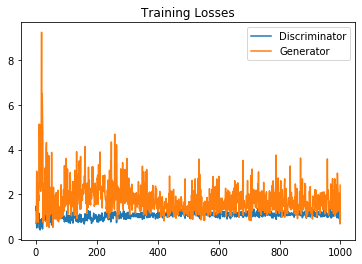

In [132]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [133]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((64,64)), cmap='Greys_r')

In [134]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

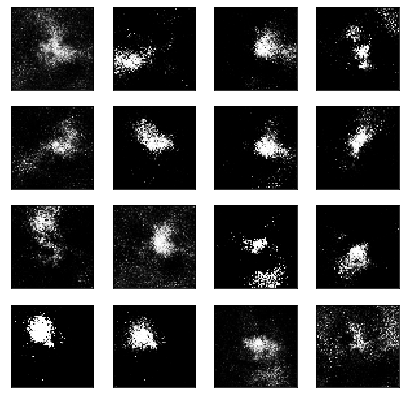

In [135]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

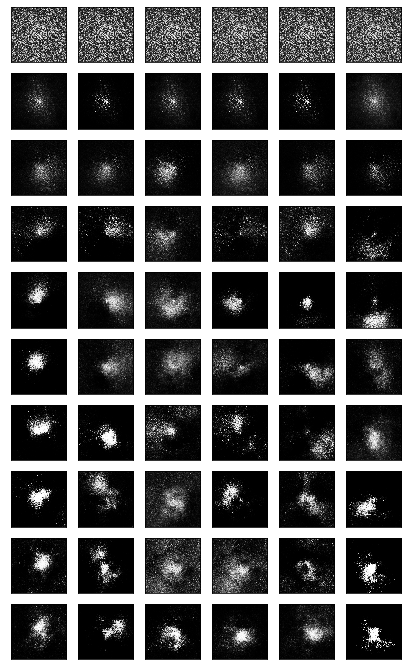

In [136]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((64,64)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)